In [1]:
import sys
sys.path.append("../utils/")

from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
import os
import glob
import seaborn as sns
import itertools
import gc
import time
import scienceplots
import librosa
from nptdms import TdmsFile
from scipy import stats
from natsort import natsorted

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import seaborn as sns
import dill as pickle
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline

from utils.preprocessing import (
    centimeter,
    one_column,
    two_column,
    cm_std,
    cm_bright,
    cm_highCon,
    cm_mark,
)

np.random.seed(16)
matplotlib.rcParams["text.usetex"] = True
plt.rcParams["text.usetex"] = True
matplotlib.rcParams["figure.dpi"] = 300
plt.style.use(["science", "nature"])
plt.rcParams["figure.constrained_layout.use"] = True
mpl.rcParams.update(one_column)

# from pydub import AudioSegment
import itertools
import string
import glob
import subprocess
import seedir
from utils.fusion import (
    compute_bdi,
    compute_ec,
    compute_st,
    process_vibration,
    process_ae,
    process_triaxial_vib,
)
from utils.preprocessing import print_tdms_structure, check_identical_csv_lengths
from utils.preprocessing import (
    linearSpectrogram,
    logMelSpectrogram,
    melSpectrogram,
    logSpectrogram,
    standardize_array,
    slice_indices,
)
from GrindingData import GrindingData
from tqdm import tqdm

alphabet = list(string.ascii_lowercase)
project_name = ["Grinding", "XiAnJiaoTong"]

if os.name == "posix":
    project_dir: str = os.path.join(
        subprocess.getoutput("echo $DATADIR"),
        *project_name,
    )
elif os.name == "nt":
    project_dir: str = os.path.join(
        subprocess.getoutput("echo %datadir%"), *project_name
    )

dataDir_ae = os.path.join(project_dir, "AE")
dataDir_vib = os.path.join(project_dir, "Vibration")
grinding_data = GrindingData(project_dir)

AE data directory: C:\Users\Public\Documents\Data\Grinding\XiAnJiaoTong\AE
Vibration data directory: C:\Users\Public\Documents\Data\Grinding\XiAnJiaoTong\Vibration


In [2]:
grinding_data._load_all_physics_data()
grinding_data._load_all_spec_data()

In [3]:
grinding_data.physical_data[grinding_data.fn_names[10]].keys()

dict_keys(['wavelet_energy_narrow', 'wavelet_energy_broad', 'burst_rate_narrow', 'burst_rate_broad', 'ec', 'bid', 'st', 'env_kurtosis_x', 'env_kurtosis_y', 'env_kurtosis_z', 'mag'])

In [4]:
spec_ae = grinding_data.spec_data[grinding_data.fn_names[11]]['spec_ae']
spec_vib = grinding_data.spec_data[grinding_data.fn_names[11]]['spec_vib']
spec_ae.shape, spec_vib.shape

((2886, 2, 300, 79), (2886, 3, 257, 21))

In [5]:
fn = grinding_data.fn_names[10]
wavelet_energy_broad = grinding_data.physical_data[fn]['wavelet_energy_broad']
wavelet_energy_narrow= grinding_data.physical_data[fn]['wavelet_energy_narrow']
burst_rate_narrow = grinding_data.physical_data[fn]['burst_rate_narrow']
burst_rate_broad = grinding_data.physical_data[fn]['burst_rate_broad']
ec = grinding_data.physical_data[fn]['ec']
st = grinding_data.physical_data[fn]['st']
bid= grinding_data.physical_data[fn]['bid']
env_kurtosis_x = grinding_data.physical_data[fn]['env_kurtosis_x']
env_kurtosis_y = grinding_data.physical_data[fn]['env_kurtosis_y']
env_kurtosis_z = grinding_data.physical_data[fn]['env_kurtosis_z']
mag = grinding_data.physical_data[fn]['mag']
sr = grinding_data.sr

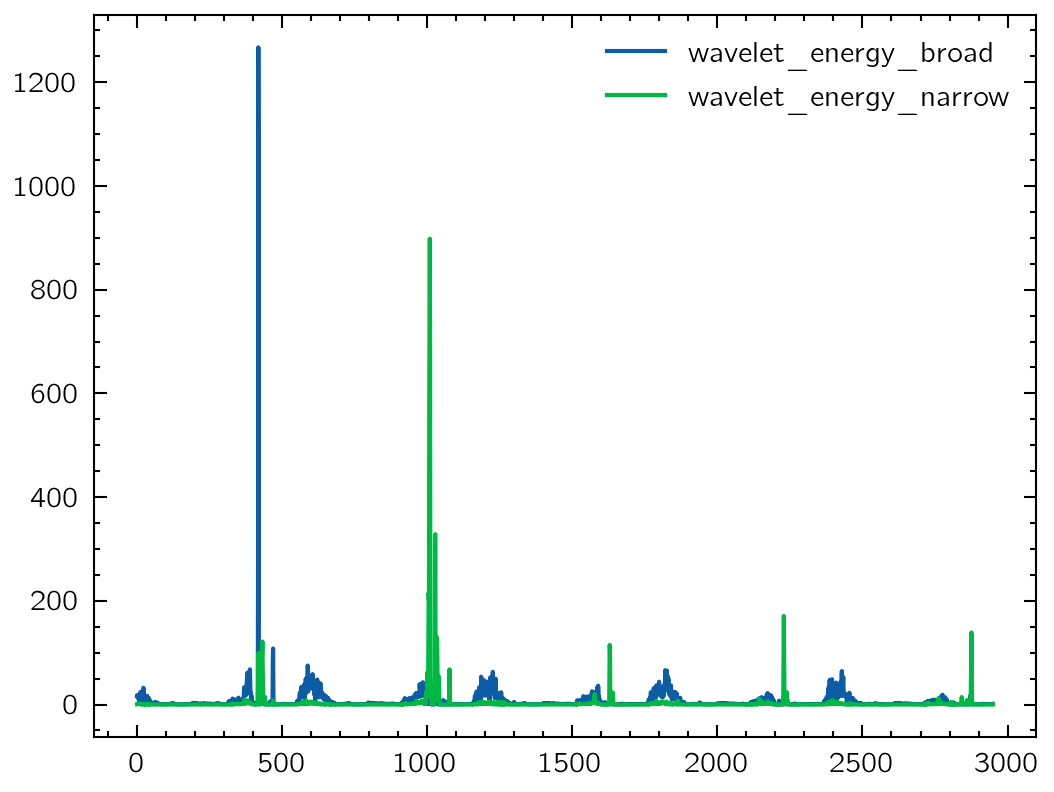

In [6]:
fig,ax = plt.subplots()
ax.plot(wavelet_energy_broad, label='wavelet_energy_broad')
ax.plot(wavelet_energy_narrow, label='wavelet_energy_narrow')
plt.legend()
plt.show()

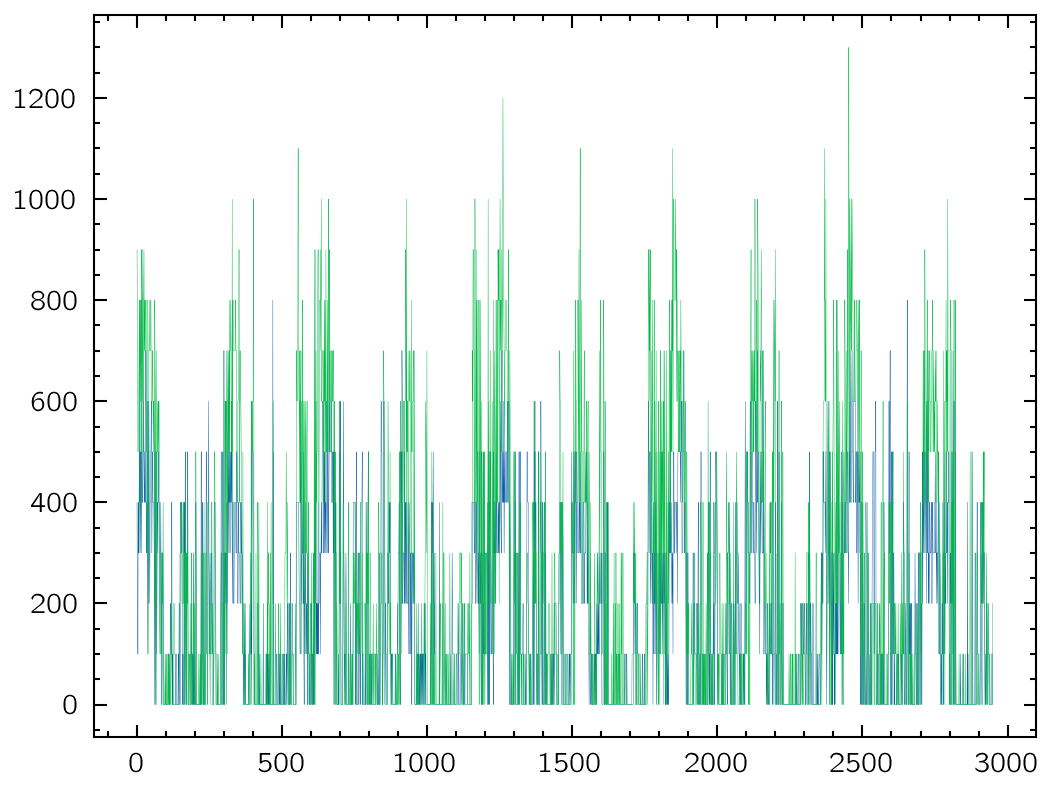

In [7]:
fig,ax = plt.subplots()
ax.plot(burst_rate_narrow, label='Burst Rate Narrow',lw=0.1)
ax.plot(burst_rate_broad, label='Burst Rate Broad',lw=0.1)
plt.show()

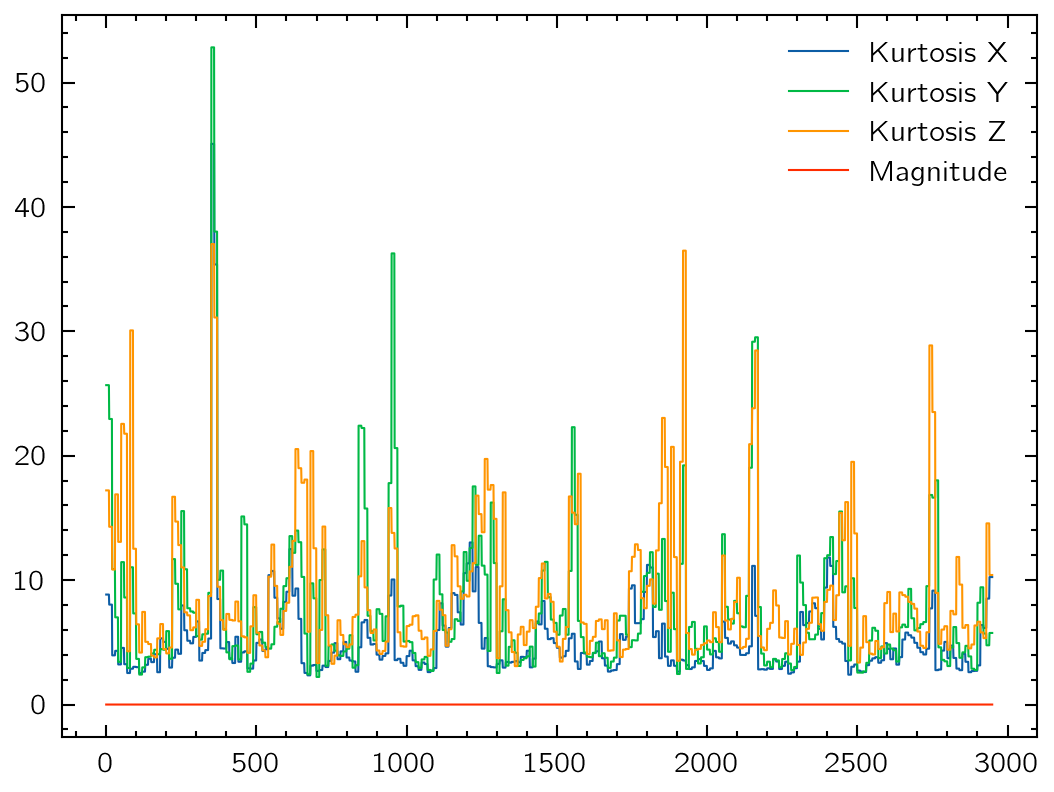

In [8]:
fig,ax = plt.subplots()
ax.plot(env_kurtosis_x, label='Kurtosis X',lw=0.5)
ax.plot(env_kurtosis_y, label='Kurtosis Y',lw=0.5)
ax.plot(env_kurtosis_z, label='Kurtosis Z',lw=0.5)
ax.plot(mag, label='Magnitude',lw=0.5)
plt.legend()
plt.show()

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class GrindingDataset(Dataset):
    def __init__(self, grinding_data):
        self.fn_names = grinding_data.fn_names
        self.physical_data = grinding_data.physical_data
        self.spec_data = grinding_data.spec_data
        self.sr  = self._normalize(grinding_data.sr)
        self.ec  = self._normalize(grinding_data.ec)
        self.st  = self._normalize(grinding_data.st)
        self.bid = self._normalize(grinding_data.bid)

    def __len__(self):
        return len(self.fn_names)

    def __getitem__(self, idx):
        fn = self.fn_names[idx]
        data = self.physical_data[fn]
        
        # Extract features
        features_ae = torch.tensor([
            self._normalize(data['wavelet_energy_broad']),
            self._normalize(data['wavelet_energy_narrow']),
            self._normalize(data['burst_rate_narrow']),
            self._normalize(data['burst_rate_broad']),
        ], dtype=torch.float32)

        features_vib = torch.tensor([
            self._normalize(data['env_kurtosis_x']),
            self._normalize(data['env_kurtosis_y']),
            self._normalize(data['env_kurtosis_z']),
            self._normalize(data['mag']),
        ], dtype=torch.float32)
        
        features_pp = torch.tensor([
            self.ec[idx],
            self.st[idx],
            self.bid[idx]
        ], dtype=torch.float32)

        # Extract sepc_data
        spec_ae = self.spec_data[fn]['spec_ae']
        spec_vib = self.spec_data[fn]['spec_vib']
       
        # Extract label
        label = self.sr[idx]
        label = torch.tensor(label, dtype=torch.long)
        
        return spec_ae, spec_vib, features_pp, features_ae, features_vib, label

    def _normalize(self, data):
        # Min-max normalization to [0, 1]
        min_val = np.min(data)
        max_val = np.max(data)
        return (data - min_val) / (max_val - min_val + 1e-8)  # Add small epsilon to avoid division by zero


def list_collate_fn(batch):
    # Return the batch as a list of tuples (features, labels)
    return list(batch)

# Assuming `grinding_data` is your data object
dataset = GrindingDataset(grinding_data)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True,collate_fn=list_collate_fn)

# # Example usage
# for batch in dataloader:
#     # print(batch_features, batch_labels)
#     print(batch)

In [ ]:
batch = next(iter(dataloader))
batch[0]

C:\Users\mingwucn\AppData\Local\Temp\ipykernel_31488\178865620.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  features_ae = torch.tensor([


In [10]:
batch[0][0].shape,batch[0][1].shape, batch[0][2].shape, batch[0][3].shape

(torch.Size([3]), torch.Size([4, 3190]), torch.Size([4, 3190]), torch.Size([]))

In [13]:
import torch
import torch.nn as nn
from einops import rearrange

class ModularPA_TFT(nn.Module):
    def __init__(self, freeze_physics=False, freeze_sensors=False):
        super().__init__()
        # Physics branch
        self.phys_proj = nn.Linear(3, 64)  # e_c', BDI, S_t
        if freeze_physics:
            for param in self.phys_proj.parameters():
                param.requires_grad = False
        
        # Sensor branch (triaxial spectrograms + scalar features)
        self.spec_encoder = nn.Conv2d(3, 64, (3,3), padding=1)  # [3, 16, T]
        self.scalar_encoder = nn.Linear(6, 64)  # 2 AE + 4 vibration scalars
        if freeze_sensors:
            for param in self.spec_encoder.parameters():
                param.requires_grad = False
            for param in self.scalar_encoder.parameters():
                param.requires_grad = False
        
        # Fusion
        self.attn = nn.MultiheadAttention(64, 4, batch_first=True)
        self.regressor = nn.Sequential(nn.Linear(64, 1))
        
    def forward(self, spec, scalars, phys):
        # Physics embedding
        phys_emb = self.phys_proj(phys).unsqueeze(1)  # [B, 1, 64]
        
        # Sensor embeddings
        spec_emb = rearrange(self.spec_encoder(spec), 'b c h t -> b t (c h)')  # [B, T, 64]
        scalar_emb = self.scalar_encoder(scalars).unsqueeze(1)  # [B, 1, 64]
        sensor_emb = torch.cat([spec_emb, scalar_emb], dim=1)  # [B, T+1, 64]
        
        # Cross-attention (sensors attend to physics)
        fused, _ = self.attn(sensor_emb, phys_emb, phys_emb)
        return self.regressor(fused.mean(dim=1))
